## Imports

Run the imports block below:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [2]:
tu = TrackIO()
for f in tu.get_tracks():
    print(f)

AWS_track.npy
AmericasGeneratedInclStart.npy
Bowtie_track.npy
Canada_Eval.npy
Canada_Training.npy
China_eval_track.npy
China_track.npy
FS_June2020.npy
H_track.npy
July_2020.npy
LGSWide.npy
London_Loop_Train.npy
Mexico_track.npy
Mexico_track_eval.npy
New_York_Eval_Track.npy
New_York_Track.npy
Oval_track.npy
Spain_track.npy
Straight_track.npy
Tokyo_Training_track.npy
Vegas_track.npy
Virtual_May19_Train_track.npy
reInvent2019_track.npy
reInvent2019_wide.npy
reInvent2019_wide_mirrored.npy
reinvent_base.npy


Loaded 155 waypoints


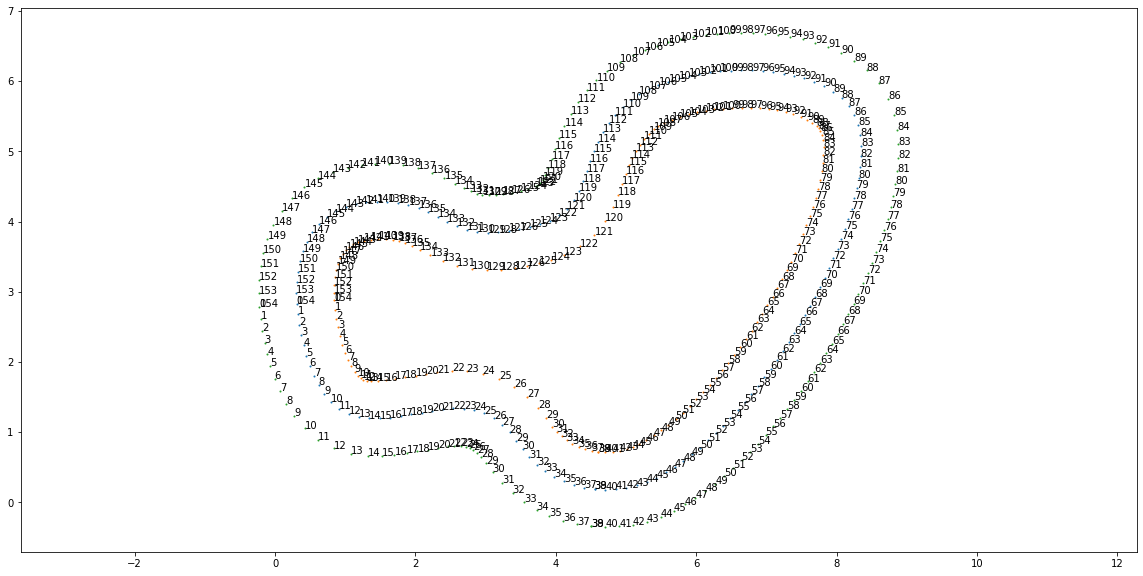

In [3]:
track: Track = tu.load_track("reInvent2019_track")

pu.plot_trackpoints(track)

In [4]:
# AWS DeepRacer Console Logs
stream_name = 'rl_coach_1418_1593168185128' ## CHANGE This to your simulation application ID
fname = './logs/%s.log' %stream_name  # The log will be downloaded into the specified path
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [5]:
EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, track.center_line, 'reward.reward_sample') #, verbose=True)
df.describe().T

Loaded 5 log files (logs rolled over)


,count,mean,std,min,25%,50%,75%,max
iteration,1120718.0,185.421573,1.035250e+02,1.0000,98.000000,184.00000,274.00000,367.0000
episode,1120718.0,3697.949457,2.070480e+03,0.0000,1948.000000,3678.00000,5474.00000,7326.0000
steps,1120718.0,81.202343,4.899377e+01,1.0000,39.000000,79.00000,122.00000,225.0000
x,1120718.0,4.255427,2.632421e+00,-0.2882,1.629700,4.46735,6.66120,9.0796
y,1120718.0,3.198881,1.805630e+00,-0.6568,1.478600,3.33450,4.75080,6.7733
yaw,1120718.0,-21.893222,1.063186e+02,-179.9999,-133.313575,-20.74770,57.39015,179.9998
steer,1120718.0,5.959639,1.518599e+01,-25.0000,0.000000,0.00000,20.00000,25.0000
throttle,1120718.0,1.999111,8.343336e-01,1.1000,1.100000,2.10000,2.50000,3.9000
action,1120718.0,4.480422,2.246230e+00,0.0000,3.000000,4.00000,6.00000,8.0000
reward,1120718.0,22.330484,2.214504e+02,-2.0000,-0.717400,5.75800,12.50680,3960.1132


In [6]:
print('Last iteration number:',df['iteration'].max())
print('Total steps in last iteration:', df[df['iteration']==df['iteration'].max()]['steps'].max())

Last iteration number: 367
Total steps in last iteration: 163


In [7]:
len(df)

1120718

# Graphs of Training Progress

new reward not found, using reward as its values
Number of episodes =  7326
Number of iterations =  367


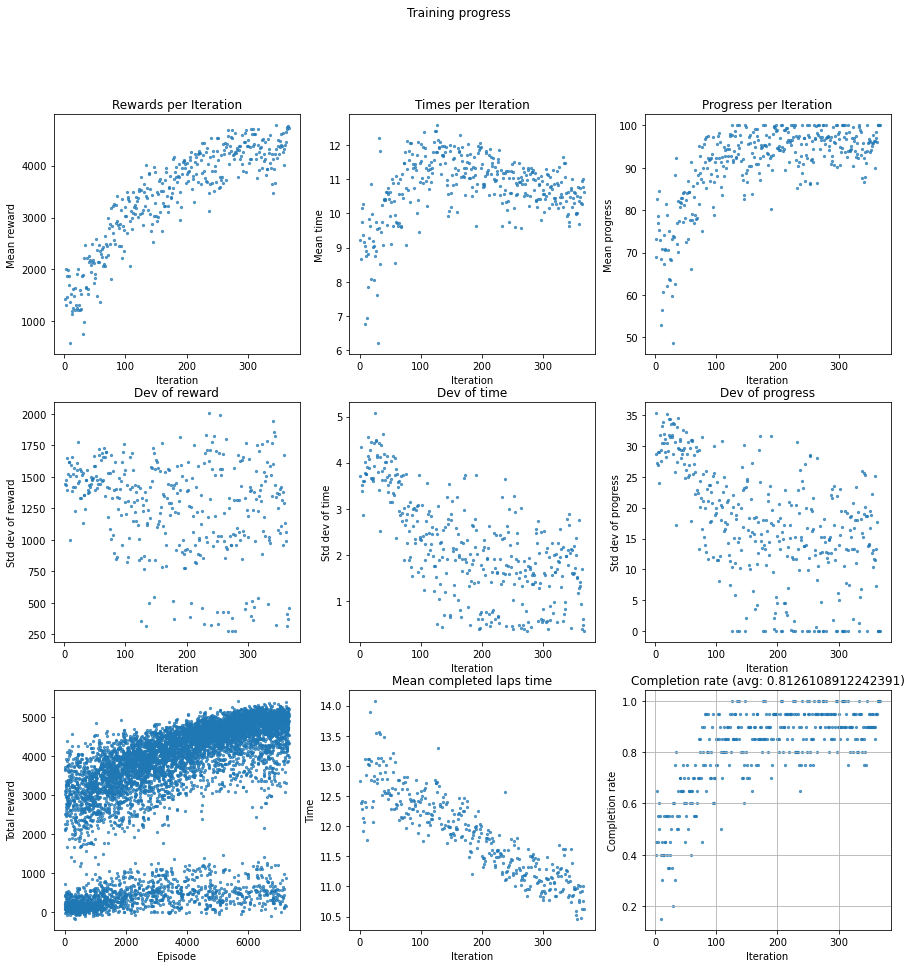

<Figure size 432x288 with 0 Axes>

In [8]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')

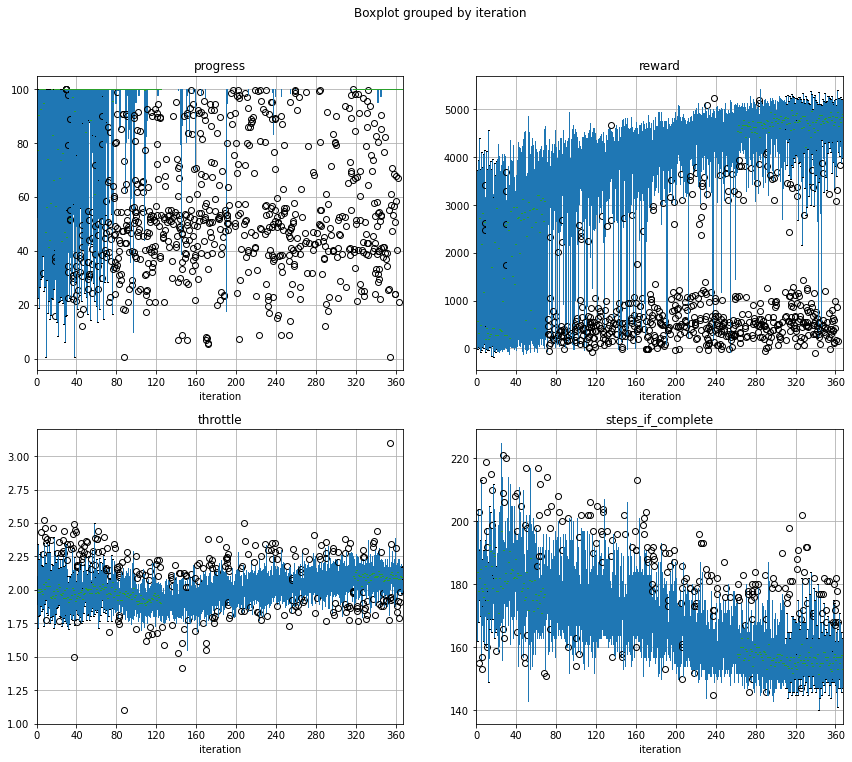

In [9]:
import numpy as np
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
df_agg = simulation_agg[['iteration','progress','reward','throttle']]
if 1 in list(simulation_agg['complete']):
    df_agg['steps_if_complete'] = simulation_agg[simulation_agg['complete']==1]['steps']
else:
    df_agg['steps'] = simulation_agg['steps']
    
for c in range(len(df_agg.columns))[1:]:
    df_agg.boxplot(column = df_agg.columns[c], by='iteration', ax=ax.flatten()[c-1])
    ax.flatten()[c-1].set_xticks(range(0,df_agg['iteration'].max(),40))
    ax.flatten()[c-1].set_xticklabels(range(0,df_agg['iteration'].max(),40))
#     if c==2:
#         ax.flatten()[c].set_ylim(bottom = df_agg['throttle'].mean()-0.5, top = df_agg['throttle'].mean()+0.5)

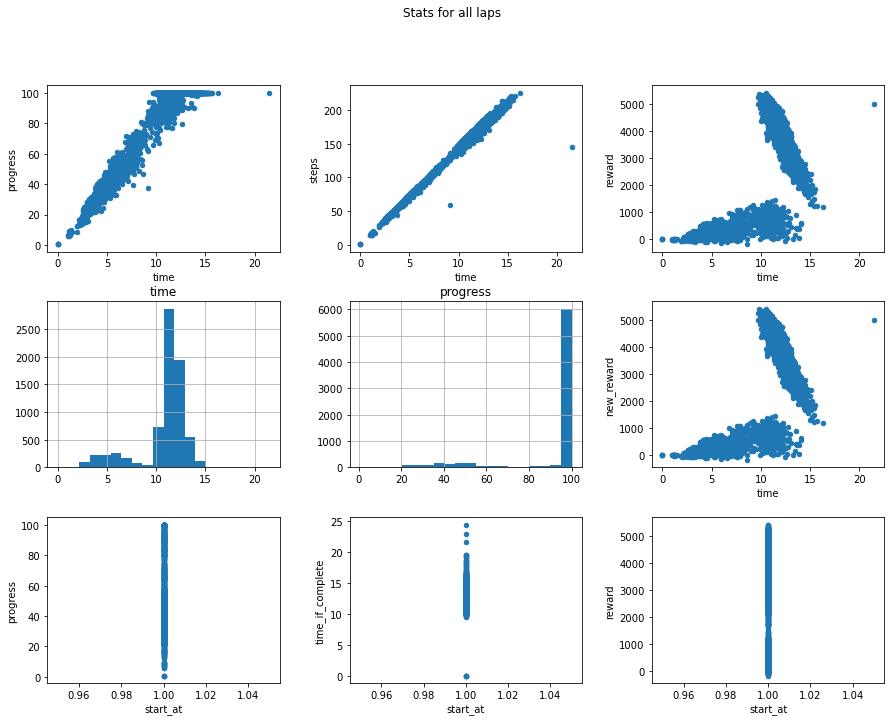

Number of episodes =  7326
Number of iterations =  367


<Figure size 432x288 with 0 Axes>

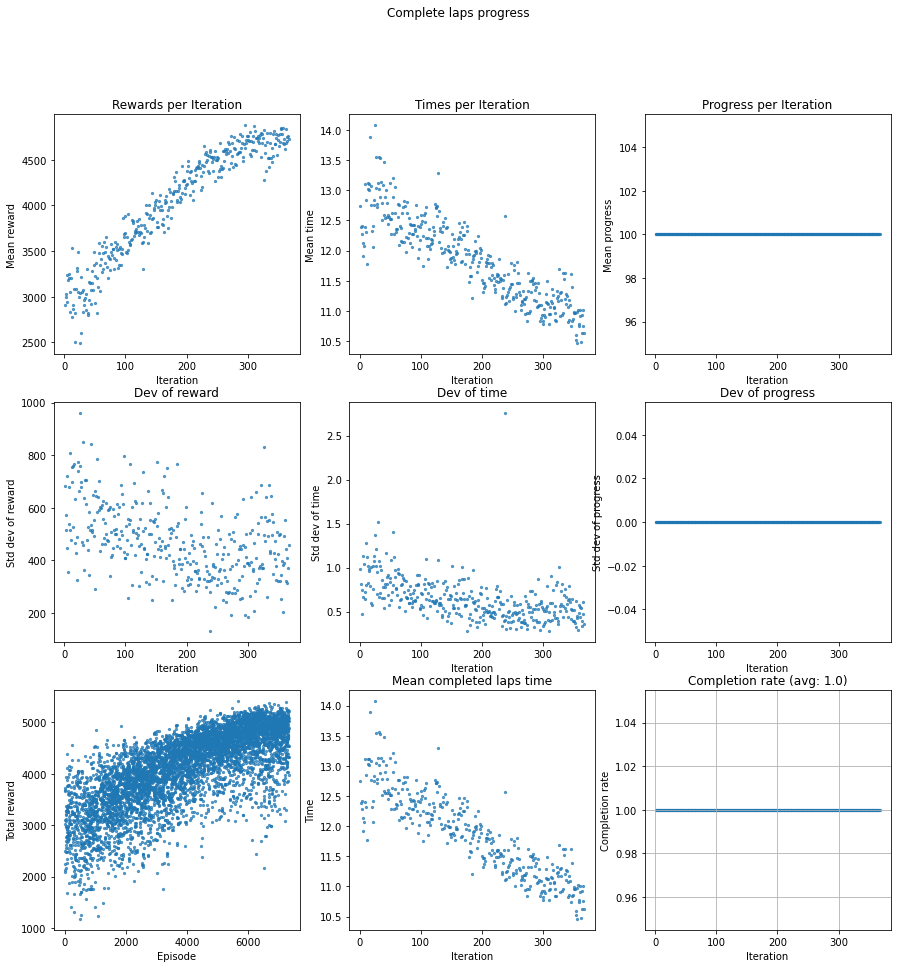

<Figure size 432x288 with 0 Axes>

In [10]:
# ### Stats for all laps
au.scatter_aggregates(simulation_agg, 'Stats for all laps')
# ### Stats for complete laps
complete_ones = simulation_agg[simulation_agg['progress']==100]
au.analyze_training_progress(complete_ones, title='Complete laps progress')

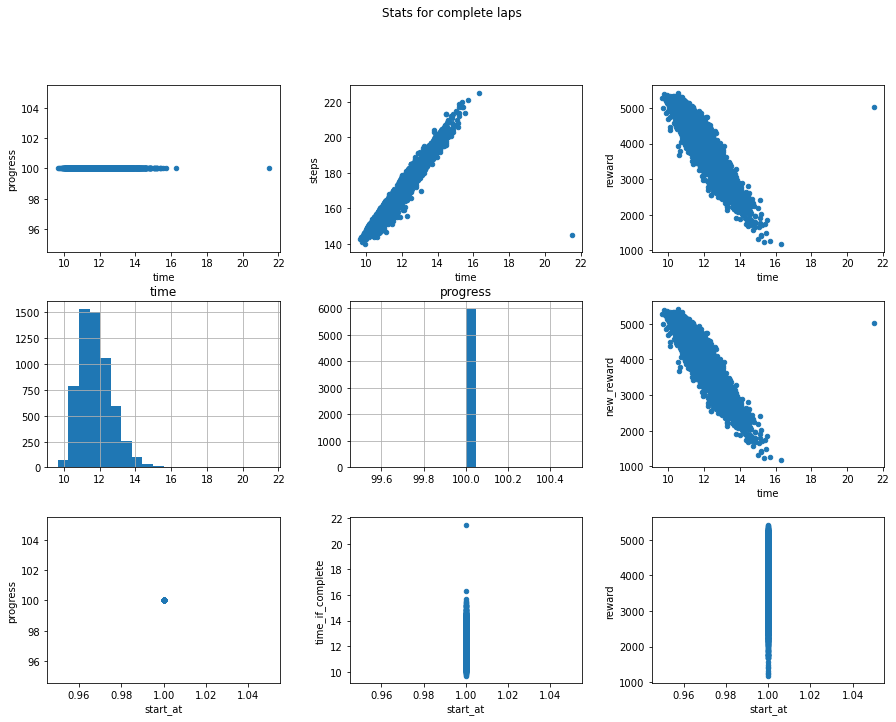

<Figure size 432x288 with 0 Axes>

In [11]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [12]:
import numpy as np
simulation_agg.groupby('iteration')['progress'].mean()

iteration
1       73.197465
2       69.055030
3       82.677750
4       78.658965
5       77.059370
          ...    
363     96.055270
364    100.000000
365    100.000000
366    100.000000
367    100.000000
Name: progress, Length: 367, dtype: float64

### Plot a training progress by quintiles

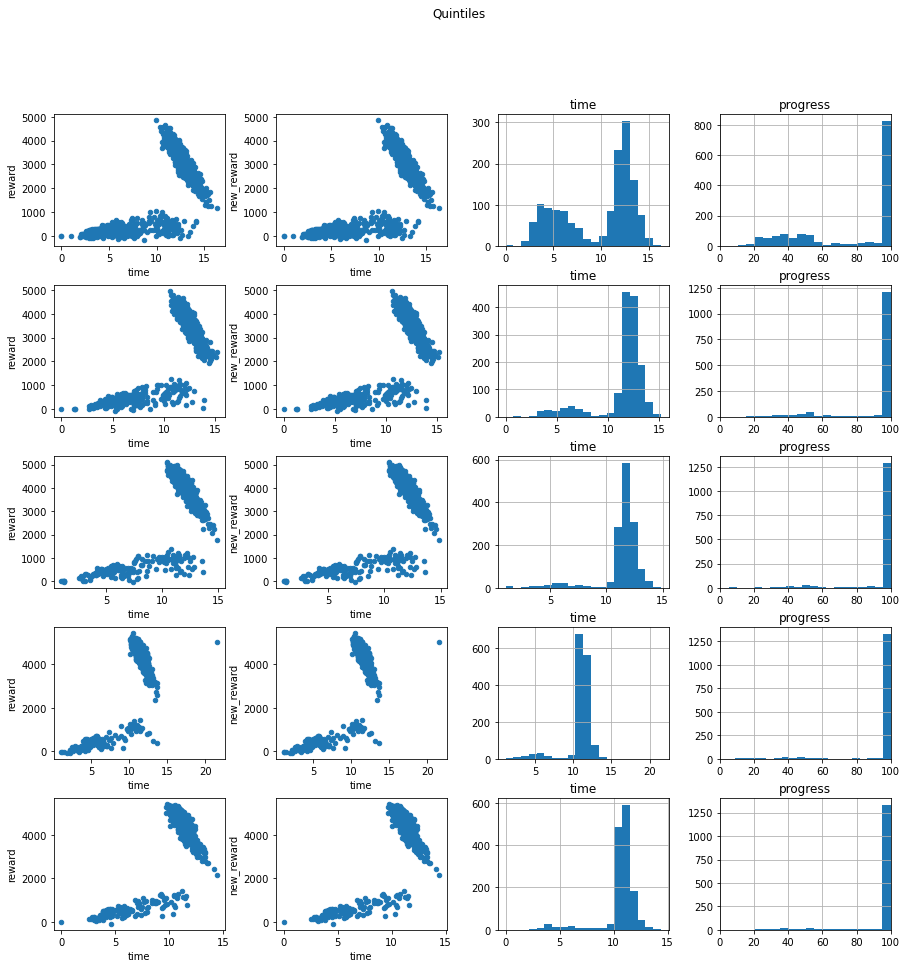

<Figure size 432x288 with 0 Axes>

In [13]:
au.scatter_by_groups(simulation_agg, title='Quintiles')

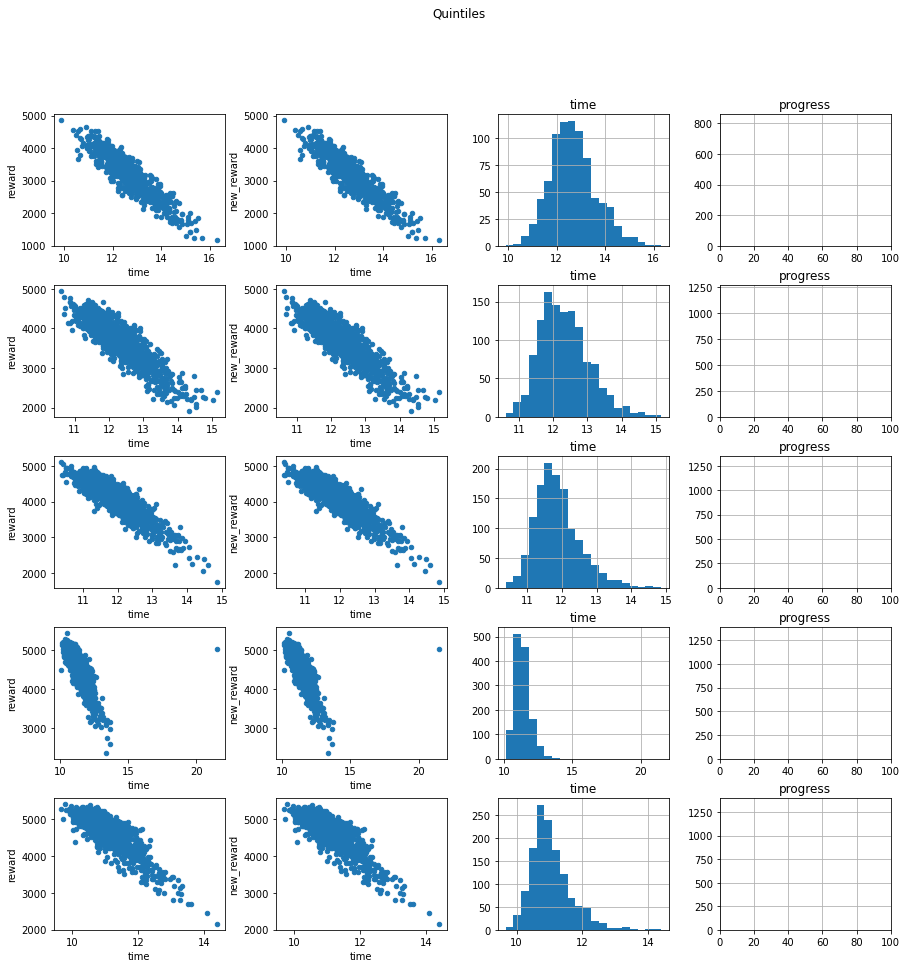

<Figure size 432x288 with 0 Axes>

In [14]:
au.scatter_by_groups(complete_ones, title='Quintiles')

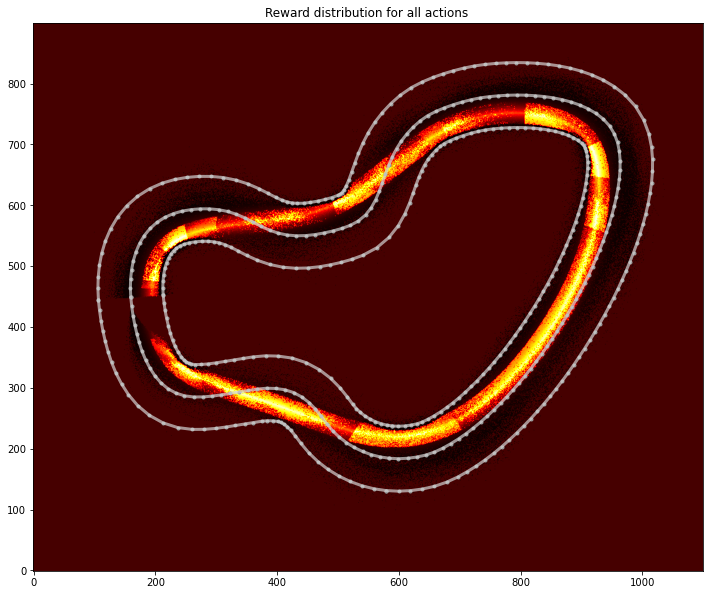

<Figure size 432x288 with 0 Axes>

In [15]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
#pu.plot_track(df[df['iteration']>80], track)
df_scaled = df
df_scaled.loc[df_scaled['progress']==100,'reward']=0
# df_scaled=df_scaled[df_scaled['iteration']>100]
pu.plot_track(df_scaled, track)

## Data in tables

In [16]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'reward').T

,5673,7235,6683,6859,6523,6970,6306,6537,6717,6234
iteration,284,362,335,343,327,349,316,327,336,312
episode,5673,7235,6683,6859,6523,6970,6306,6537,6717,6234
steps,145,141,148,140,145,146,145,145,146,144
start_at,1,1,1,1,1,1,1,1,1,1
progress,100,100,100,100,100,100,100,100,100,100
time,10.5497,9.77823,10.5352,9.95022,10.3145,10.0981,10.4505,10.2894,10.748,10.1395
new_reward,5420.7,5400.89,5374.58,5363.73,5339.09,5334.92,5324.92,5324.34,5320.75,5298.34
throttle,2.23379,2.21489,2.16757,2.25,2.22828,2.20411,2.18966,2.24759,2.19589,2.31667
reward,5420.7,5400.89,5374.58,5363.73,5339.09,5334.92,5324.92,5324.34,5320.75,5298.34
time_if_complete,10.5497,9.77823,10.5352,9.95022,10.3145,10.0981,10.4505,10.2894,10.748,10.1395


In [17]:
# View five fastest complete laps
print('Total number of episodes ',max(simulation_agg['episode']))
complete_ones.nsmallest(10, 'time').T

Total number of episodes  7326


,7223,7084,7235,7049,7313,7043,1020,7256,5922,6859
iteration,362,355,362,353,366,353,52,363,297,343
episode,7223,7084,7235,7049,7313,7043,1020,7256,5922,6859
steps,143,144,141,145,146,146,143,147,143,140
start_at,1,1,1,1,1,1,1,1,1,1
progress,100,100,100,100,100,100,100,100,100,100
time,9.66867,9.70352,9.77823,9.82097,9.88789,9.88917,9.89033,9.93105,9.94257,9.95022
new_reward,5278.62,5008.58,5400.89,5251.14,5208.09,5273.82,4852.99,5237.26,5134.51,5363.73
throttle,2.23287,2.21111,2.21489,2.14966,2.16712,2.20411,2.24266,2.23197,2.21608,2.25
reward,5278.62,5008.58,5400.89,5251.14,5208.09,5273.82,4852.99,5237.26,5134.51,5363.73
time_if_complete,9.66867,9.70352,9.77823,9.82097,9.88789,9.88917,9.89033,9.93105,9.94257,9.95022


### Path taken and throttle values in a particular episode

Fastest episode number: 7223
Lap time: 9.67
Steps: 143.00


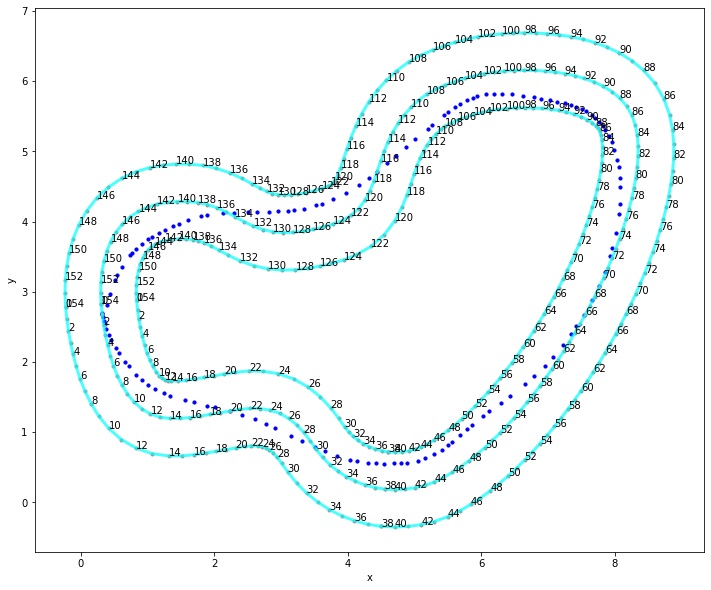

<Figure size 432x288 with 0 Axes>

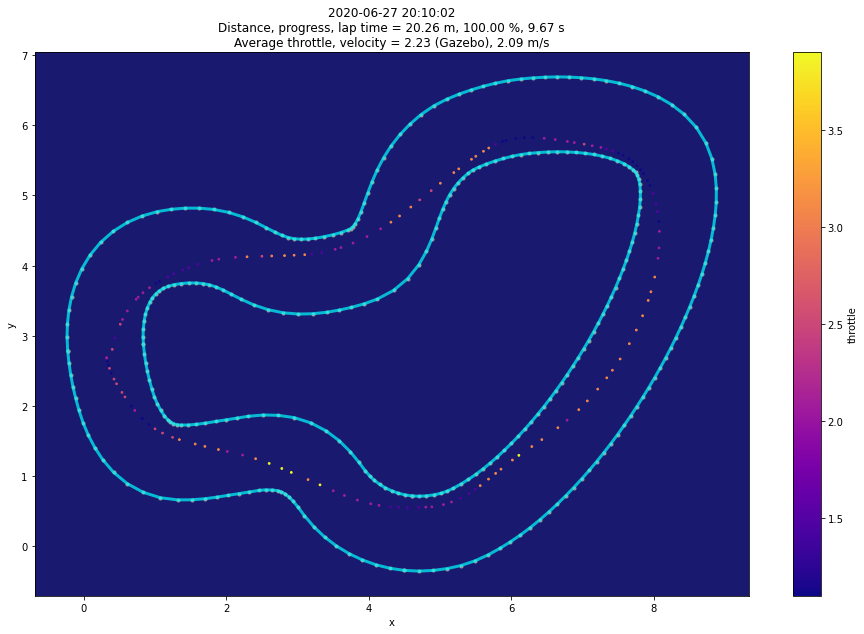

<Figure size 432x288 with 0 Axes>

In [18]:
episode_id = simulation_agg[simulation_agg['progress']==100]['time'].idxmin()
print('Fastest episode number: ' "{:0.0f}".format(episode_id))
print('Lap time: ' "{:0.2f}".format(float(simulation_agg[simulation_agg['episode']==episode_id]['time'])))
print('Steps: ' "{:0.2f}".format(float(simulation_agg[simulation_agg['episode']==episode_id]['steps'])))
pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df, track)
pu.plot_grid_world(df[df['episode']==episode_id], track)

## Analyze the reward distribution for your reward function

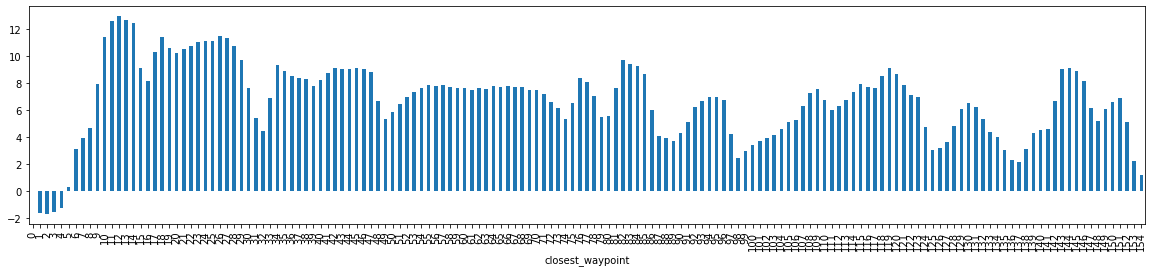

In [19]:
episode = df.groupby('closest_waypoint').mean()['reward']
episode[0:].plot.bar(x='closest_waypoint', y='reward')
fig = plt.gcf()
fig.set_size_inches(20,4)

# out = pd.cut(s, bins=[0, 0.35, 0.7, 1], include_lowest=True)
# ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
# ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
# plt.show()

### Path taken in a particular iteration

In [20]:
simulation_agg['iteration'].max()

367

last complete iteration is  366


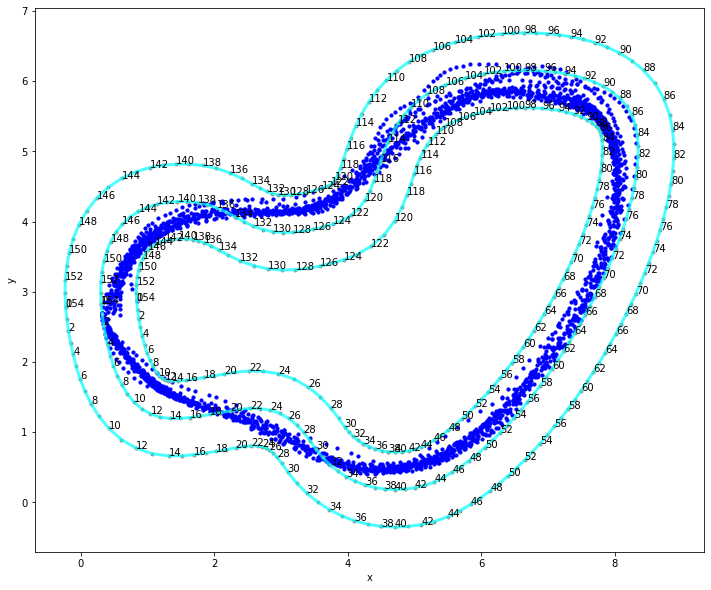

<Figure size 432x288 with 0 Axes>

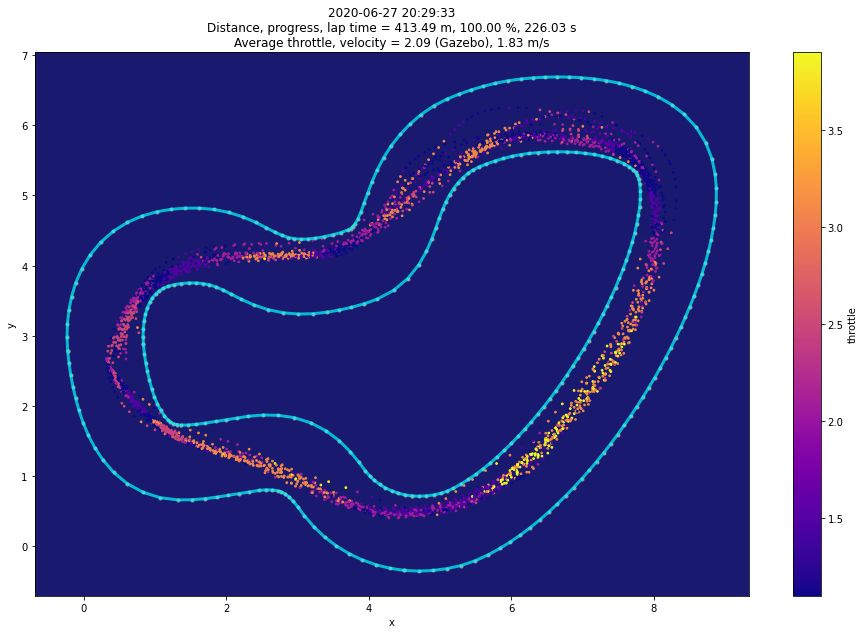

<Figure size 432x288 with 0 Axes>

In [21]:
iteration_id = simulation_agg['iteration'].max()-1
print('last complete iteration is ', iteration_id)
pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')
pu.plot_grid_world(df[df['iteration']==iteration_id], track)

in between iteration  184.0


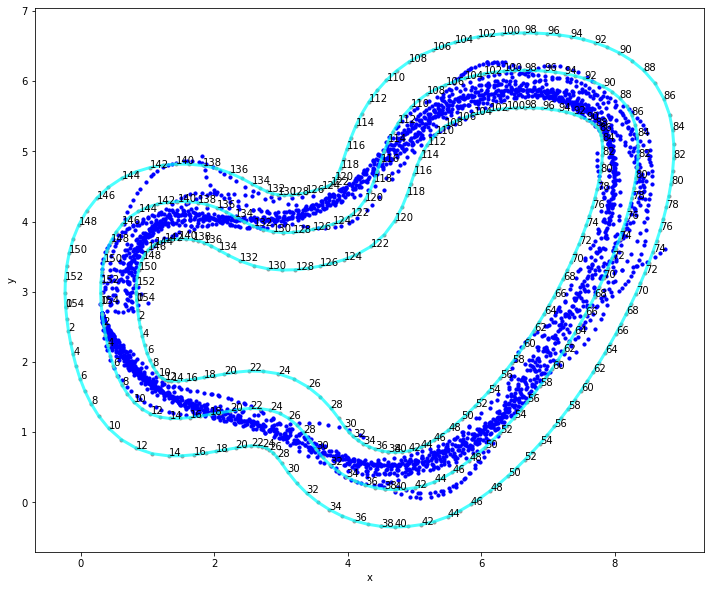

<Figure size 432x288 with 0 Axes>

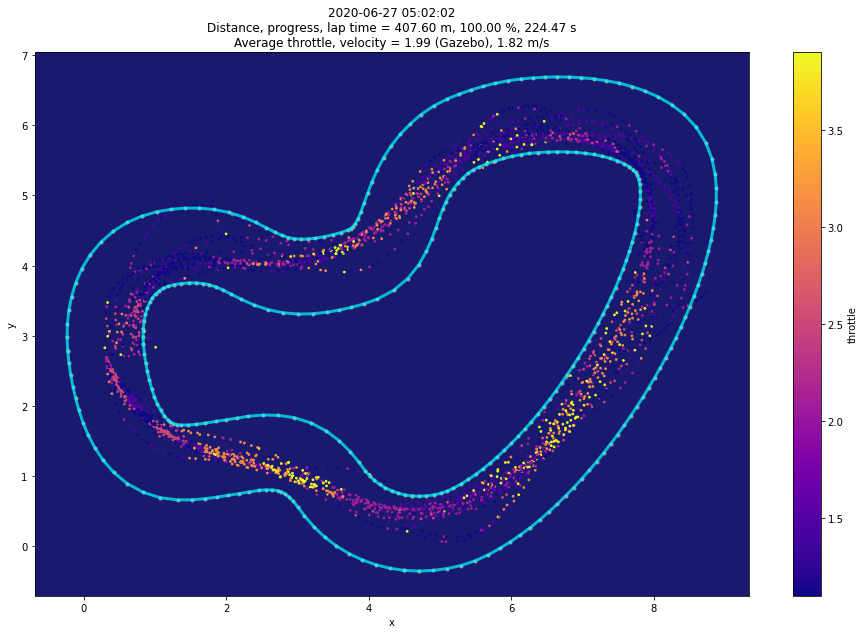

<Figure size 432x288 with 0 Axes>

In [22]:
iteration_id = round((simulation_agg['iteration'].max())/2)
print('in between iteration ', iteration_id)
pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')
pu.plot_grid_world(df[df['iteration']==iteration_id], track)

first iteration  1


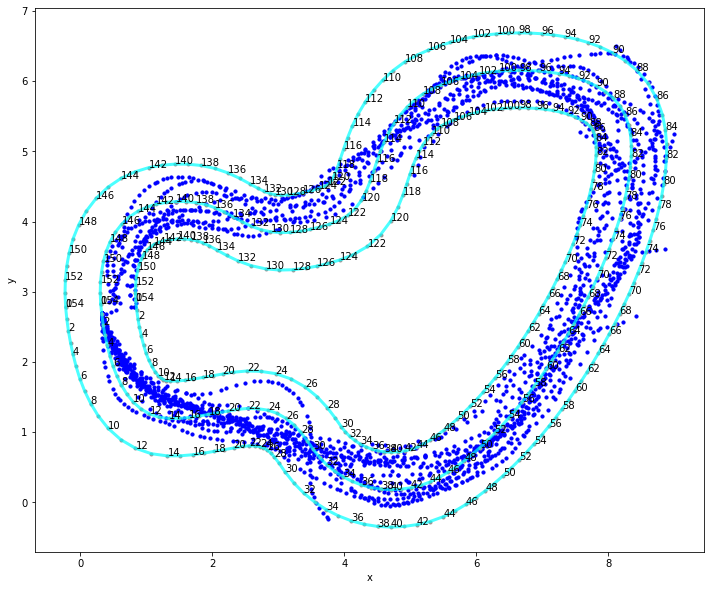

<Figure size 432x288 with 0 Axes>

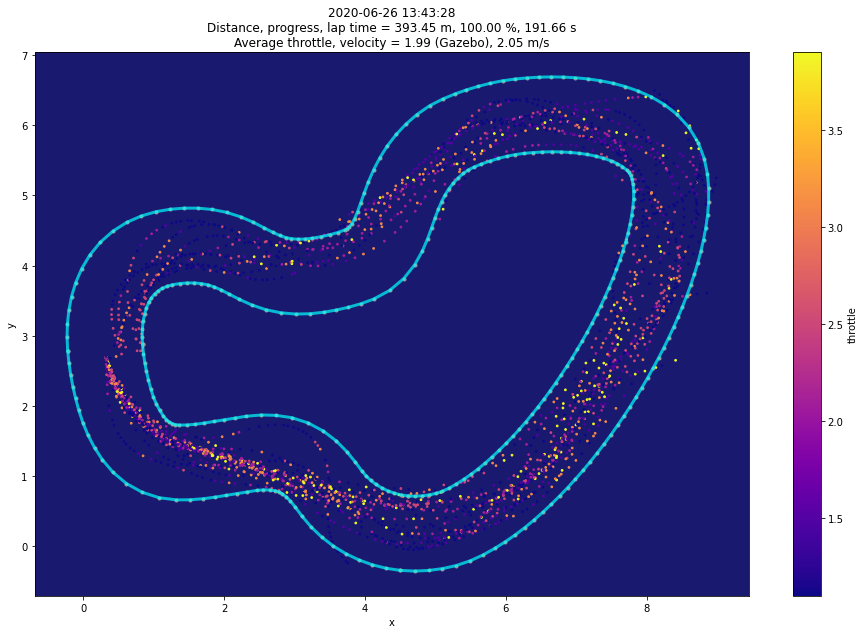

<Figure size 432x288 with 0 Axes>

In [23]:
iteration_id = 1
print('first iteration ', iteration_id)
pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')
pu.plot_grid_world(df[df['iteration']==iteration_id], track)